# REDHEN DATA ANALYSIS 

## LIBRARIES 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# DataFrame
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [4]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

In [5]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [6]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## SETTINGS 

In [7]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model_individual.h5"
WORD2VEC_MODEL = "model_individual.w2v"
TOKENIZER_MODEL = "tokenizer_individual.pkl"
ENCODER_MODEL = "encoder_individual.pkl"

## READING DATASET 

In [8]:
data = pd.read_csv('redhen_preprocessed.csv')
data.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,ACCOUNT_Individual,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
0,7992,NI3079,Elliot Rodger Wangs roommate stabbed Wang and ...,EVENT,0,0,0,0,99,1,...,99,0,34,215.0,elliot rodger wangs roommate stabbed wang two ...,"['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'..."
1,4686,NI2689,Because the tragedy unfolded at the start of a...,RESOURCES,0,0,0,0,99,0,...,99,0,32,228.0,tragedy unfolded start holiday weekend school ...,"['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee..."
2,6130,NI2400,Gunrelated restraining orders Also passed in r...,"POLICY, POLICY- Guns, POLICY- Mental health",0,0,0,0,99,0,...,99,0,122,734.0,gunrelated restraining orders also passed resp...,"['gunrelated', 'restraining', 'orders', 'also'...","['gunrelated', 'restraining', 'orders', 'also'...","['gunrel', 'restrain', 'order', 'also', 'pass'...","['gunrelated', 'restraining', 'order', 'also',...","['gunrel', 'restrain', 'order', 'also', 'pass'..."
3,5876,NI1393,Linder said she will also remember Weiss for h...,"VICTIMS, GRIEF/LOSS",0,0,0,0,99,0,...,99,1,100,499.0,linder said also remember weiss epic shot pool...,"['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'rememb', 'weiss', ...","['linder', 'said', 'also', 'remember', 'wei', ...","['linder', 'said', 'also', 'rememb', 'weiss', ..."
4,4126,NI3259,I mean I know how this goes We all do Werent y...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,85,425.0,mean know goes werent sort expecting father on...,"['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...","['mean', 'know', 'go', 'werent', 'sort', 'expe...","['mean', 'know', 'goe', 'werent', 'sort', 'exp..."


In [9]:
data.shape

(8131, 62)

In [10]:
data.rename(columns={'ACCOUNT_Individual': 'target'}, inplace=True)
data.head()

,Unnamed: 0,StoryID,Excerpt,CodesApplied_Combined,ACCOUNT,ACCOUNT_Cultural,target,ACCOUNT_Other,COMMUNITYRECOVERY,EVENT,...,TRAUMA_Societal,VICTIMS,word_count,char_count,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean
0,7992,NI3079,Elliot Rodger Wangs roommate stabbed Wang and ...,EVENT,0,0,0,0,99,1,...,99,0,34,215.0,elliot rodger wangs roommate stabbed wang two ...,"['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'..."
1,4686,NI2689,Because the tragedy unfolded at the start of a...,RESOURCES,0,0,0,0,99,0,...,99,0,32,228.0,tragedy unfolded start holiday weekend school ...,"['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee..."
2,6130,NI2400,Gunrelated restraining orders Also passed in r...,"POLICY, POLICY- Guns, POLICY- Mental health",0,0,0,0,99,0,...,99,0,122,734.0,gunrelated restraining orders also passed resp...,"['gunrelated', 'restraining', 'orders', 'also'...","['gunrelated', 'restraining', 'orders', 'also'...","['gunrel', 'restrain', 'order', 'also', 'pass'...","['gunrelated', 'restraining', 'order', 'also',...","['gunrel', 'restrain', 'order', 'also', 'pass'..."
3,5876,NI1393,Linder said she will also remember Weiss for h...,"VICTIMS, GRIEF/LOSS",0,0,0,0,99,0,...,99,1,100,499.0,linder said also remember weiss epic shot pool...,"['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'rememb', 'weiss', ...","['linder', 'said', 'also', 'remember', 'wei', ...","['linder', 'said', 'also', 'rememb', 'weiss', ..."
4,4126,NI3259,I mean I know how this goes We all do Werent y...,"ACCOUNTABILITY, ACCOUNT- Culture/societal risk...",1,1,0,0,99,0,...,99,0,85,425.0,mean know goes werent sort expecting father on...,"['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...","['mean', 'know', 'go', 'werent', 'sort', 'expe...","['mean', 'know', 'goe', 'werent', 'sort', 'exp..."


In [14]:
data.columns

Index(['Unnamed: 0', 'StoryID', 'Excerpt', 'CodesApplied_Combined', 'ACCOUNT',
       'ACCOUNT_Cultural', 'target', 'ACCOUNT_Other', 'COMMUNITYRECOVERY',
       'EVENT', 'GRIEF', 'GRIEF_Individual', 'GRIEF_Community',
       'GRIEF_Societal', 'HERO', 'INVESTIGATION', 'JOURNEY', 'JOURNEY_Mental',
       'JOURNEY_Physical', 'LEGAL', 'MEDIA', 'MISCELLANEOUS', 'MOURNING',
       'MOURNING_Individual', 'MOURNING_Community', 'MOURNING_Societal',
       'PERPETRATOR', 'PHOTO', 'POLICY', 'POLICY_Guns', 'POLICY_InfoSharing',
       'POLICY_MentalHealth', 'POLICY_Other', 'POLICY_VictimAdv',
       'POLICY_OtherAdv', 'POLICY_Practice', 'PRIVATESECTOR', 'RACECULTURE',
       'RESOURCES', 'SAFETY', 'SAFETY_Community', 'SAFETY_Individual',
       'SAFETY_SchoolOrg', 'SAFETY_Societal', 'SOCIALSUPPORT', 'THREAT',
       'THREAT_Assessment', 'TRAUMA', 'TRAUMA_Physical',
       'TRAUMA_Psychological', 'TRAUMA_Individual', 'TRAUMA_Community',
       'TRAUMA_Societal', 'VICTIMS', 'word_count', 'char_count

In [15]:
data = data[['StoryID', 'Excerpt','Excerpt_pre',
       'Excerpt_tokenized', 'Excerpt_nonstop', 'Excerpt_stemmed',
       'Excerpt_lemmatized', 'Excerpt_clean', 'target']]
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
0,NI3079,Elliot Rodger Wangs roommate stabbed Wang and ...,elliot rodger wangs roommate stabbed wang two ...,"['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...",0
1,NI2689,Because the tragedy unfolded at the start of a...,tragedy unfolded start holiday weekend school ...,"['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...",0
2,NI2400,Gunrelated restraining orders Also passed in r...,gunrelated restraining orders also passed resp...,"['gunrelated', 'restraining', 'orders', 'also'...","['gunrelated', 'restraining', 'orders', 'also'...","['gunrel', 'restrain', 'order', 'also', 'pass'...","['gunrelated', 'restraining', 'order', 'also',...","['gunrel', 'restrain', 'order', 'also', 'pass'...",0
3,NI1393,Linder said she will also remember Weiss for h...,linder said also remember weiss epic shot pool...,"['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'rememb', 'weiss', ...","['linder', 'said', 'also', 'remember', 'wei', ...","['linder', 'said', 'also', 'rememb', 'weiss', ...",0
4,NI3259,I mean I know how this goes We all do Werent y...,mean know goes werent sort expecting father on...,"['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...","['mean', 'know', 'go', 'werent', 'sort', 'expe...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...",0


In [16]:
data.shape

(8131, 9)

In [17]:
data_in = data.loc[data['target'] == 1]
data_in.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
65,NI2577,One thing for sure Every legal expert agrees t...,one thing sure every legal expert agrees rodge...,"['one', 'thing', 'sure', 'every', 'legal', 'ex...","['one', 'thing', 'sure', 'every', 'legal', 'ex...","['one', 'thing', 'sure', 'everi', 'legal', 'ex...","['one', 'thing', 'sure', 'every', 'legal', 'ex...","['one', 'thing', 'sure', 'everi', 'legal', 'ex...",1
73,NI3119,Certainly the latest murderous rampage carried...,certainly latest murderous rampage carried you...,"['certainly', 'latest', 'murderous', 'rampage'...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c...","['certainly', 'latest', 'murderous', 'rampage'...","['certainli', 'latest', 'murder', 'rampag', 'c...",1
74,NI1605,In a 137page manifesto Rodger wrote that he wo...,137page manifesto rodger wrote would commit ma...,"['137page', 'manifesto', 'rodger', 'wrote', 'w...","['137page', 'manifesto', 'rodger', 'wrote', 'w...","['137page', 'manifesto', 'rodger', 'wrote', 'w...","['137page', 'manifesto', 'rodger', 'wrote', 'w...","['page', 'manifesto', 'rodger', 'wrote', 'woul...",1
76,NI2957,Some crackpot who couldnt get a date stabs and...,crackpot couldnt get date stabs shoots way acr...,"['crackpot', 'couldnt', 'get', 'date', 'stabs'...","['crackpot', 'couldnt', 'get', 'date', 'stabs'...","['crackpot', 'couldnt', 'get', 'date', 'stab',...","['crackpot', 'couldnt', 'get', 'date', 'stab',...","['crackpot', 'couldnt', 'get', 'date', 'stab',...",1
83,NI2915,I got into an online debate recently with Lind...,got online debate recently lindsay beyerstein ...,"['got', 'online', 'debate', 'recently', 'linds...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',...","['got', 'online', 'debate', 'recently', 'linds...","['got', 'onlin', 'debat', 'recent', 'lindsay',...",1


In [18]:
data_in.shape

(788, 9)

In [19]:
data_unin = data.loc[data['target'] == 0]
data_unin.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
0,NI3079,Elliot Rodger Wangs roommate stabbed Wang and ...,elliot rodger wangs roommate stabbed wang two ...,"['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...","['elliot', 'rodger', 'wangs', 'roommate', 'sta...","['elliot', 'rodger', 'wang', 'roommat', 'stab'...",0
1,NI2689,Because the tragedy unfolded at the start of a...,tragedy unfolded start holiday weekend school ...,"['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...","['tragedy', 'unfolded', 'start', 'holiday', 'w...","['tragedi', 'unfold', 'start', 'holiday', 'wee...",0
2,NI2400,Gunrelated restraining orders Also passed in r...,gunrelated restraining orders also passed resp...,"['gunrelated', 'restraining', 'orders', 'also'...","['gunrelated', 'restraining', 'orders', 'also'...","['gunrel', 'restrain', 'order', 'also', 'pass'...","['gunrelated', 'restraining', 'order', 'also',...","['gunrel', 'restrain', 'order', 'also', 'pass'...",0
3,NI1393,Linder said she will also remember Weiss for h...,linder said also remember weiss epic shot pool...,"['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'remember', 'weiss'...","['linder', 'said', 'also', 'rememb', 'weiss', ...","['linder', 'said', 'also', 'remember', 'wei', ...","['linder', 'said', 'also', 'rememb', 'weiss', ...",0
4,NI3259,I mean I know how this goes We all do Werent y...,mean know goes werent sort expecting father on...,"['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goes', 'werent', 'sort', 'ex...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...","['mean', 'know', 'go', 'werent', 'sort', 'expe...","['mean', 'know', 'goe', 'werent', 'sort', 'exp...",0


In [21]:
data_unin.shape

(7343, 9)

In [22]:
data_unin = data_unin.sample(788)
data_unin.shape

(788, 9)

In [24]:
from sklearn.utils import shuffle
dataframe = [data_in, data_unin]
data = pd.concat(dataframe)
data = shuffle(data)
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
3661,NI2857,I dont know why you girls arent attracted to m...,dont know girls arent attracted punish elliot ...,"['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girl', 'arent', 'attract', '...","['dont', 'know', 'girl', 'arent', 'attracted',...","['dont', 'know', 'girl', 'arent', 'attract', '...",1
2833,NI2087,My clients mission in life will be to try to p...,clients mission life try prevent tragedies eve...,"['clients', 'mission', 'life', 'try', 'prevent...","['clients', 'mission', 'life', 'try', 'prevent...","['client', 'mission', 'life', 'tri', 'prevent'...","['client', 'mission', 'life', 'try', 'prevent'...","['client', 'mission', 'life', 'tri', 'prevent'...",0
2612,NI1124,\nShifman said the family called police severa...,shifman said family called police several week...,"['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...",1
4900,NI2924,Without doubt 22yearold Elliot Rodger was a si...,without doubt 22yearold elliot rodger sick you...,"['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', 'yearold', 'elliot', 'rod...",1
1547,NI2940,A 22yearold student last Friday killed six peo...,22yearold student last friday killed six peopl...,"['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['yearold', 'student', 'last', 'friday', 'kill...",0


In [25]:
data.shape

(1576, 9)

In [27]:
decode_map = {0: "NO", 1: "YES"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [28]:
%%time
data.target = data.target.apply(lambda x: decode_sentiment(x))

CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 230 ms


In [29]:
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
3661,NI2857,I dont know why you girls arent attracted to m...,dont know girls arent attracted punish elliot ...,"['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girl', 'arent', 'attract', '...","['dont', 'know', 'girl', 'arent', 'attracted',...","['dont', 'know', 'girl', 'arent', 'attract', '...",YES
2833,NI2087,My clients mission in life will be to try to p...,clients mission life try prevent tragedies eve...,"['clients', 'mission', 'life', 'try', 'prevent...","['clients', 'mission', 'life', 'try', 'prevent...","['client', 'mission', 'life', 'tri', 'prevent'...","['client', 'mission', 'life', 'try', 'prevent'...","['client', 'mission', 'life', 'tri', 'prevent'...",NO
2612,NI1124,\nShifman said the family called police severa...,shifman said family called police several week...,"['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...",YES
4900,NI2924,Without doubt 22yearold Elliot Rodger was a si...,without doubt 22yearold elliot rodger sick you...,"['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', 'yearold', 'elliot', 'rod...",YES
1547,NI2940,A 22yearold student last Friday killed six peo...,22yearold student last friday killed six peopl...,"['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['yearold', 'student', 'last', 'friday', 'kill...",NO


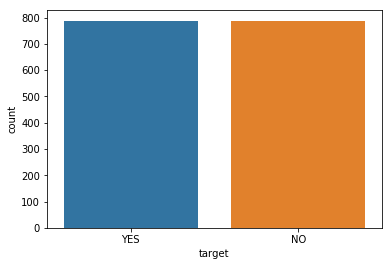

In [30]:
import seaborn as sns
sns.countplot(x = 'target', data = data)

## PREPROCESS DATASET 

In [31]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [32]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [33]:
%%time
data.Excerpt = data.Excerpt.apply(lambda x: preprocess(x))

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 333 ms


In [34]:
data.columns

Index(['StoryID', 'Excerpt', 'Excerpt_pre', 'Excerpt_tokenized',
       'Excerpt_nonstop', 'Excerpt_stemmed', 'Excerpt_lemmatized',
       'Excerpt_clean', 'target'],
      dtype='object')

## SPLITTING TRAINING AND TESTING 

In [35]:
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1260
TEST size: 316


## WORD2VEC 

In [36]:
%%time
documents = [_text.split() for _text in df_train.Excerpt] 

CPU times: user 5.06 ms, sys: 131 µs, total: 5.19 ms
Wall time: 5.12 ms


In [37]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [38]:
w2v_model.build_vocab(documents)

2019-04-06 17:45:39,286 : INFO : collecting all words and their counts
2019-04-06 17:45:39,287 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-06 17:45:39,300 : INFO : collected 6840 word types from a corpus of 63631 raw words and 1260 sentences
2019-04-06 17:45:39,302 : INFO : Loading a fresh vocabulary
2019-04-06 17:45:39,315 : INFO : effective_min_count=10 retains 1322 unique words (19% of original 6840, drops 5518)
2019-04-06 17:45:39,316 : INFO : effective_min_count=10 leaves 49763 word corpus (78% of original 63631, drops 13868)
2019-04-06 17:45:39,321 : INFO : deleting the raw counts dictionary of 6840 items
2019-04-06 17:45:39,322 : INFO : sample=0.001 downsamples 61 most-common words
2019-04-06 17:45:39,323 : INFO : downsampling leaves estimated 44549 word corpus (89.5% of prior 49763)
2019-04-06 17:45:39,326 : INFO : estimated required memory for 1322 words and 300 dimensions: 3833800 bytes
2019-04-06 17:45:39,327 : INFO : resetting layer we

In [39]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1322


In [40]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-04-06 17:45:57,588 : INFO : training model with 8 workers on 1322 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-04-06 17:45:57,604 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:45:57,628 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:45:57,633 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:45:57,642 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:45:57,650 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:45:57,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:45:57,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:45:57,656 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:45:57,657 : INFO : EPOCH - 1 : training on 63631 raw words (44565 effective words) took 0.1s, 792464 effectiv

2019-04-06 17:45:58,207 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:45:58,210 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:45:58,211 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:45:58,213 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:45:58,214 : INFO : EPOCH - 10 : training on 63631 raw words (44487 effective words) took 0.1s, 782331 effective words/s
2019-04-06 17:45:58,222 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:45:58,249 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:45:58,259 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:45:58,267 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:45:58,269 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:45:58,270 : INFO : worker thread 

2019-04-06 17:45:58,793 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:45:58,812 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:45:58,830 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:45:58,832 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:45:58,834 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:45:58,842 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:45:58,843 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:45:58,847 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:45:58,847 : INFO : EPOCH - 20 : training on 63631 raw words (44555 effective words) took 0.1s, 767686 effective words/s
2019-04-06 17:45:58,855 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:45:58,877 : INFO : worker thread 

2019-04-06 17:45:59,420 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:45:59,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-06 17:45:59,424 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-06 17:45:59,425 : INFO : EPOCH - 29 : training on 63631 raw words (44511 effective words) took 0.1s, 769920 effective words/s
2019-04-06 17:45:59,434 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-06 17:45:59,455 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-06 17:45:59,466 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-06 17:45:59,480 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-06 17:45:59,481 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-06 17:45:59,482 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-06 17:45:59,484 : INFO : worker thread 

CPU times: user 7.52 s, sys: 186 ms, total: 7.7 s
Wall time: 2.02 s


(1425548, 2036192)

In [41]:
w2v_model.most_similar("rampage")

/home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-04-06 17:46:32,683 : INFO : precomputing L2-norms of word weight vectors


[('murderous', 0.7228012084960938),
 ('screed', 0.707252025604248),
 ('near', 0.6996663808822632),
 ('seaside', 0.6612381935119629),
 ('friday', 0.6590067148208618),
 ('six', 0.6426867246627808),
 ('23', 0.638489305973053),
 ('deadly', 0.6066614985466003),
 ('carefully', 0.6052719354629517),
 ('killing', 0.5978062748908997)]

## TOKENIZE TEXT 

In [42]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Excerpt)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 6841
CPU times: user 66.8 ms, sys: 97 µs, total: 66.8 ms
Wall time: 65.8 ms


In [43]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Excerpt), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Excerpt), maxlen=SEQUENCE_LENGTH)

CPU times: user 64.2 ms, sys: 3.69 ms, total: 67.9 ms
Wall time: 67 ms


In [44]:
data.head()

,StoryID,Excerpt,Excerpt_pre,Excerpt_tokenized,Excerpt_nonstop,Excerpt_stemmed,Excerpt_lemmatized,Excerpt_clean,target
3661,NI2857,dont know girls arent attracted punish elliot ...,dont know girls arent attracted punish elliot ...,"['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girls', 'arent', 'attracted'...","['dont', 'know', 'girl', 'arent', 'attract', '...","['dont', 'know', 'girl', 'arent', 'attracted',...","['dont', 'know', 'girl', 'arent', 'attract', '...",YES
2833,NI2087,clients mission life try prevent tragedies eve...,clients mission life try prevent tragedies eve...,"['clients', 'mission', 'life', 'try', 'prevent...","['clients', 'mission', 'life', 'try', 'prevent...","['client', 'mission', 'life', 'tri', 'prevent'...","['client', 'mission', 'life', 'try', 'prevent'...","['client', 'mission', 'life', 'tri', 'prevent'...",NO
2612,NI1124,shifman said family called police several week...,shifman said family called police several week...,"['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...","['shifman', 'said', 'family', 'called', 'polic...","['shifman', 'said', 'famili', 'call', 'polic',...",YES
4900,NI2924,without doubt 22yearold elliot rodger sick you...,without doubt 22yearold elliot rodger sick you...,"['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', '22yearold', 'elliot', 'r...","['without', 'doubt', 'yearold', 'elliot', 'rod...",YES
1547,NI2940,22yearold student last friday killed six peopl...,22yearold student last friday killed six peopl...,"['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['22yearold', 'student', 'last', 'friday', 'ki...","['yearold', 'student', 'last', 'friday', 'kill...",NO


## LABEL ENCODER 

In [45]:
labels = df_train.target.unique().tolist()
labels

['YES', 'NO']

In [46]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

LabelEncoder()

In [47]:
y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

In [48]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [49]:
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1260, 1)
y_test (316, 1)


In [50]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1260, 300)
y_train (1260, 1)

x_test (316, 300)
y_test (316, 1)


In [51]:
y_train[:10]

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

## EMBEDDING LAYER

In [52]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(6841, 300)


In [53]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## BUILD MODEL

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-04-06 17:49:27,960 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-04-06 17:49:28,034 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          2052300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,212,801
Trainable params: 160,501
Non-trainable params: 2,052,300
_________________________________________________________________


## COMPILE MODEL 

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## CALLBACKS 

In [56]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## TRAIN 

In [57]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-04-06 17:50:22,877 : WARNING : From /home/spriyanshu723/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1134 samples, validate on 126 samples
Epoch 1/8
1134/1134 [==============================] - 7s 6ms/step - loss: 0.6921 - acc: 0.5423 - val_loss: 0.5860 - val_acc: 0.7381
Epoch 2/8
1134/1134 [==============================] - 5s 5ms/step - loss: 0.6245 - acc: 0.6922 - val_loss: 0.5332 - val_acc: 0.7222
Epoch 3/8
1134/1134 [==============================] - 5s 5ms/step - loss: 0.5742 - acc: 0.7240 - val_loss: 0.4979 - val_acc: 0.7540
Epoch 4/8
1134/1134 [==============================] - 5s 5ms/step - loss: 0.5479 - acc: 0.7513 - val_loss: 0.4727 - val_acc: 0.7540
Epoch 5/8
1134/1134 [==============================] - 5s 5ms/step - loss: 0.5172 - acc: 0.7566 - val_loss: 0.4492 - val_acc: 0.7778
Epoch 6/8
1134/1134 [==============================] - 5s 5ms/step - loss: 0.4954 - acc: 0.7698 - val_loss: 0.4205 - val_acc: 0.7937
Epoch 7/8
1134/1134 [==============================] - 5s 4ms/step - loss: 0.4626 - acc: 0.7963 - val_loss: 0.3858 - val_acc: 0.8095
Epoch 8/8
1134/1134 [=

## EVALUATE 

In [58]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

316/316 [==============================] - 1s 2ms/step

ACCURACY: 0.7848101258277893
LOSS: 0.4619891047477722
CPU times: user 2.46 s, sys: 388 ms, total: 2.84 s
Wall time: 519 ms


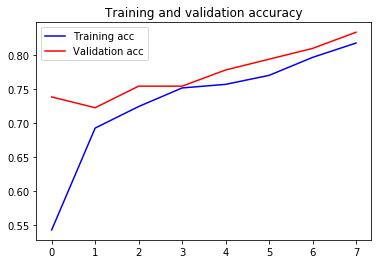

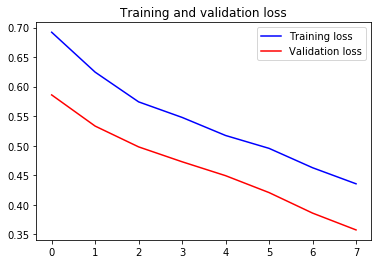

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## PREDICT 

In [60]:
def decode_hate(score):
    if score < 0.51:
        return "YES"
    else:
        return "NO"

In [61]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_hate(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [62]:
predict("President Killing shock the country")

{'label': 'YES',
 'score': 0.11762671172618866,
 'elapsed_time': 0.23705434799194336}